In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import random
from tqdm import tqdm
from scipy import stats

In [2]:
from torchvision.io import read_image
import torchvision.transforms as T

In [3]:
%load_ext autoreload
%autoreload 2

---

In [4]:
DATA_DIR = '/data/ltorres'

In [5]:
torch.manual_seed(7)
np.random.seed(7)
random.seed(7)

---

### Functions

In [6]:
def get_paths(data_dir, dataset_type):
    return glob.glob(
                     os.path.join(data_dir,f'GCD/{dataset_type}/**/*.jpg'), 
                     recursive=True
                    )

In [7]:
def get_class(paths):
        return ["_".join(os.path.basename(x).split('.')[0].split('_')[:2]) for x in paths]

In [8]:
train_paths = get_paths(DATA_DIR, "train")

### Lectura de datos

In [58]:
train_paths = get_paths(DATA_DIR, "train")
train_class = get_class(paths)

df_train = pd.DataFrame({'path':train_paths, 'class':train_class})

In [62]:
test_paths = get_paths(DATA_DIR, "test")
test_class = get_class(test_paths)

df_test = pd.DataFrame({'path':test_paths, 'class':test_class})

### 1. Distribucion

In [302]:
plot_data_train = df_train["class"].value_counts().sort_index().reset_index()
plot_data_train.columns = ["clase", "cantidad"]

plot_data_test = df_test["class"].value_counts().sort_index().reset_index()
plot_data_test.columns = ["clase", "cantidad"]

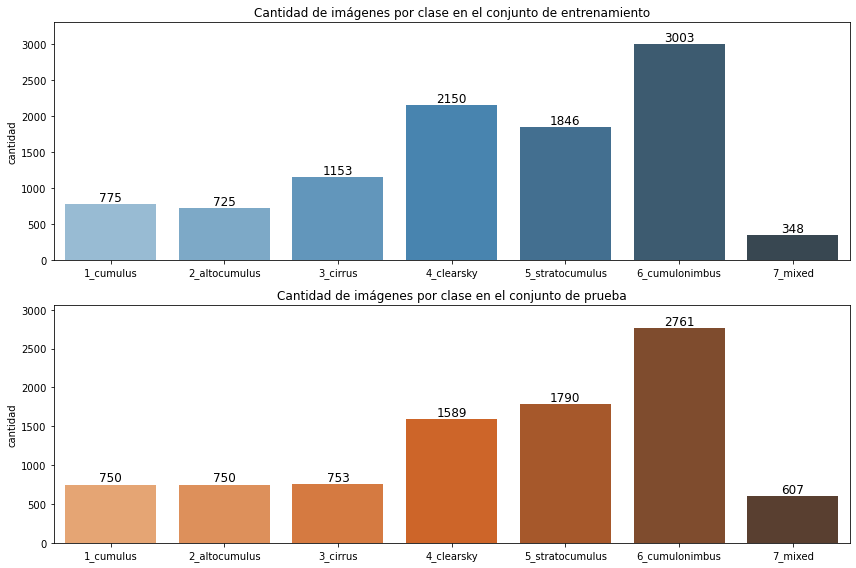

In [322]:
fig, axs = plt.subplots(2, gridspec_kw={'height_ratios': [1, 1]})
fig.set_figwidth(12)
fig.set_figheight(8)

ax = sns.barplot(ax=axs[0], data=plot_data_train, x="clase", y="cantidad", palette="Blues_d")
ax.bar_label(ax.containers[0], fontsize=12)
axs[0].set_ylim( 0, plot_data_train["cantidad"].max() + 300)
axs[0].title.set_text('Cantidad de imágenes por clase en el conjunto de entrenamiento')
axs[0].set_xlabel('')

ax = sns.barplot(ax=axs[1], data=plot_data_test, x="clase", y="cantidad", palette="Oranges_d")
ax.bar_label(ax.containers[0], fontsize=12)
axs[1].set_ylim( 0, plot_data_test["cantidad"].max() + 300)
axs[1].title.set_text('Cantidad de imágenes por clase en el conjunto de prueba')
axs[1].set_xlabel('')

plt.subplots_adjust(hspace=0.4, bottom=0.2)

fig.tight_layout()
fig.savefig('assets/distrubucion_gcd')
plt.show()


### 2. Estadisticos por canal RGB

In [202]:
class Dataset:
    def __init__(self, image_paths):
        self.image_paths  = image_paths
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):
        image = read_image(self.image_paths[item]).float()

        return image

In [204]:
train_dataset = Dataset(train_paths)

In [205]:
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=32,
        num_workers=6,
        shuffle=True,
    )

In [229]:
#https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch

nimages = 0
mean = 0.0
var = 0.0
for i_batch, batch_target in tqdm(enumerate(train_loader), total=len(train_loader)):
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute mean and std here
    mean += batch.mean(2).sum(0) 
    var += batch.var(2).sum(0)

mean /= nimages
var /= nimages
std = torch.sqrt(var)

100%|██████████| 313/313 [00:12<00:00, 25.71it/s]


In [248]:
def norm_plot(curves, title):
    """
    Plots normal distribution curves
    curves: list of tuples like: (mu, sigma, label)
    """
    fig, ax = plt.subplots()
    for mu, sigma, label, color in curves:
        x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
        ax.plot(x, stats.norm.pdf(x, mu, sigma), label=label, color=color)

    ax.set_title(title)
    ax.legend()
    
    fig.tight_layout()
    fig.savefig('assets/distrubucion_pixeles_gcd')

In [249]:
curves = [
    (mean[0], std[0], 'Canal R', "red"),
    (mean[1], std[1], 'Canal G', "green"),
    (mean[2], std[2], 'Canal B', "blue"),
]

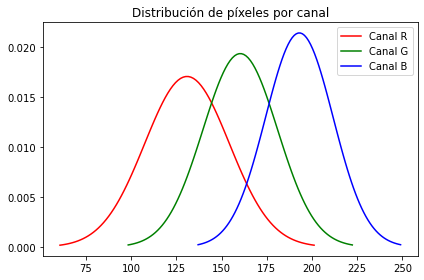

In [250]:
norm_plot(curves, "Distribución de píxeles por canal")

In [251]:
mean

tensor([130.9360, 160.3594, 193.0078])

In [252]:
std

tensor([23.4079, 20.6422, 18.6495])

### 3. Ejemplares

In [262]:
base = '/data/ltorres/GCD/train'
path_1 = '/3_cirrus/3_cirrus_000003.jpg'
path_2 = '/3_cirrus/3_cirrus_000015.jpg'
path_3 = '/5_stratocumulus/5_stratocumulus_000018.jpg'

In [275]:
images = list()
for i in range(3):
    p = base+str(eval(f"path_{i+1}"))
    images.append(read_image(p))   

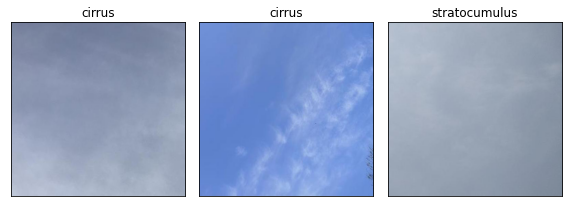

In [292]:
fig, axs = plt.subplots(1,3)
fig.set_figwidth(10)
fig.set_figheight(5)

axs[0].imshow(images[0].numpy().transpose(1,2,0))
axs[0].title.set_text('cirrus')

axs[1].imshow(images[1].numpy().transpose(1,2,0))
axs[1].title.set_text('cirrus')

axs[2].imshow(images[2].numpy().transpose(1,2,0))
axs[2].title.set_text('stratocumulus')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
fig.savefig('assets/ejemplos_gcd')
plt.show()

### 4. Scaling

In [355]:
train_paths[0]

'/data/ltorres/GCD/train/1_cumulus/1_cumulus_000286.jpg'

In [334]:
img = read_image(train_paths[0]).float()

In [335]:
transform = T.Normalize(mean=[mean[0], mean[1], mean[2]], 
                        std=[std[0], std[1], std[2]])

In [342]:
norm_img = transform(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


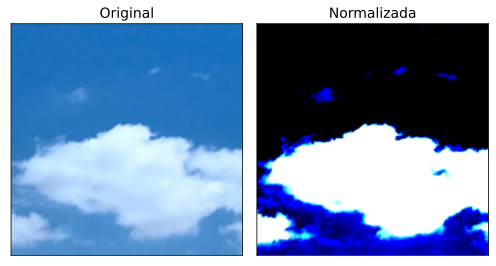

In [359]:
%config InlineBackend.figure_format = 'svg'

fig, axs = plt.subplots(1,2)
fig.set_figwidth(7)
fig.set_figheight(4)

axs[0].imshow(img.int().numpy().transpose(1,2,0))
axs[0].title.set_text('Original')
axs[0].title.set_fontsize(14)

axs[1].imshow(norm_img.numpy().transpose(1,2,0))
axs[1].title.set_text('Normalizada')
axs[1].title.set_fontsize(14)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
fig.savefig('assets/gcd_scaling')
plt.show()

### 5. Augmentation

#### flip

In [365]:
h_flip = T.RandomHorizontalFlip(1)
v_flip = T.RandomVerticalFlip(1)

In [366]:
img = read_image(train_paths[0])

h_img = h_flip(img)
v_img = v_flip(img)

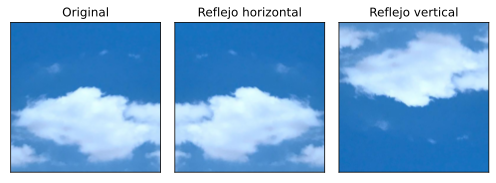

In [382]:
fig, axs = plt.subplots(1,3)
fig.set_figwidth(7)
fig.set_figheight(4)

axs[0].imshow(img.int().numpy().transpose(1,2,0))
axs[0].title.set_text('Original')
axs[0].title.set_fontsize(12)

axs[1].imshow(h_img.numpy().transpose(1,2,0))
axs[1].title.set_text('Reflejo horizontal')
axs[1].title.set_fontsize(12)

axs[2].imshow(v_img.numpy().transpose(1,2,0))
axs[2].title.set_text('Reflejo vertical')
axs[2].title.set_fontsize(12)


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
fig.savefig('assets/augmentation_flip')
plt.show()

#### rotation

In [383]:
rot_25 = T.RandomRotation((25,25))
rot_12 = T.RandomRotation((12,12))

In [384]:
img = read_image(train_paths[0])

rot_25_img = rot_25(img)
rot_12_img = rot_12(img)

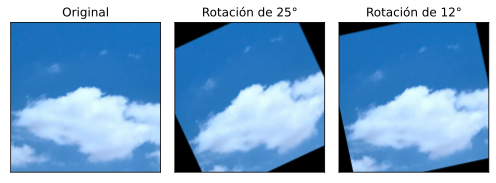

In [386]:
fig, axs = plt.subplots(1,3)
fig.set_figwidth(7)
fig.set_figheight(4)

axs[0].imshow(img.int().numpy().transpose(1,2,0))
axs[0].title.set_text('Original')
axs[0].title.set_fontsize(12)

axs[1].imshow(rot_25_img.numpy().transpose(1,2,0))
axs[1].title.set_text('Rotación de 25°')
axs[1].title.set_fontsize(12)

axs[2].imshow(rot_12_img.numpy().transpose(1,2,0))
axs[2].title.set_text('Rotación de 12°')
axs[2].title.set_fontsize(12)


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
fig.savefig('assets/augmentation_rotation')
plt.show()